# Differential Dynamic Programming for inverted pendulum 

Let $\mathbf{x} = [p, \dot{p}, \theta, \dot{\theta}]^\top \in \mathbb{R}^4$ be a state vector, where $p$ is horizontal cart position, $\dot{p} = \frac{d p}{dt} = v$ is cart velocity, $\theta$ is pole angle, and $\dot{\theta} = \frac{d \theta}{dt} = \omega$ is pole angular velocity.    

Let $\mathbf{u} = [F] \in \mathbb{R}$ be a control vector, where $F\in [-1, 1]$ is a force exerted to the cart.  

Import necessary modules

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mbrl
import mbrl.env.cartpole_continuous
import time
from IPython import display
%matplotlib inline

Define a class to describe a cartpole system


In [2]:
class InvertedPendulum:

    def __init__(self):
        # ddp iteration
        self.iteration = 5
        # dimensions for control and state
        u_dim = 1
        x_dim = 4
        # time horizon
        self.T = 200 
        # time step interval
        self.dt = 0.02 # gym system parameter... fixed
        # control u to be optimized
        self.u = jnp.ones((self.T, u_dim), dtype=float) # dim: T x u_dim
        # state x to be optimized
        self.x = jnp.zeros((self.T, x_dim), dtype=float) # dim: T x x_dim 
        self.updated_x = jnp.zeros((self.T, x_dim), dtype=float) # dim: T x x_dim 
        self.desired_terminal_state = jnp.array([0, 0, jnp.pi, 0], dtype=float)
        # state x for test
        self.test_x = jnp.zeros((self.T, x_dim), dtype=float) # dim: T x x_dim 
        self.test_updated_x = jnp.zeros((self.T, x_dim), dtype=float) # dim: T x x_dim 
        # initializing the initial state
        self.x = self.x.at[0].set([0, 0, jnp.pi, 0])
        self.updated_x = self.updated_x.at[0].set([0, 0, jnp.pi, 0])
        self.test_x = self.test_x.at[0].set([0, 0, jnp.pi, 0])
        self.test_updated_x = self.test_updated_x.at[0].set([0, 0, jnp.pi, 0])
        # gains to be optimized
        self.k = jnp.zeros((self.T, u_dim), dtype=float) # dim: T x u_dim
        self.K = jnp.zeros((self.T, u_dim, x_dim), dtype=float) # dim: T x u_dim x x_dim
        # coefficients for the quadratic cost
        self.P = jnp.eye(x_dim, x_dim, dtype=float) # dim: x_dim x x_dim
        self.P = self.P.at[0, 0].set(10)
        self.P = self.P.at[2, 2].set(10)
        self.R = jnp.eye(u_dim, u_dim, dtype=float) # dim: u_dim x u_dim
        self.R = self.R.at[0, 0].set(10)

        # mbrl environments
        self.env = mbrl.env.cartpole_continuous.CartPoleEnv()
        self.test_env = mbrl.env.cartpole_continuous.CartPoleEnv()

        # system parameters: https://github.com/facebookresearch/mbrl-lib/blob/main/mbrl/env/cartpole_continuous.py
        self.g = 9.8 # gravitational constant
        self.M = 1 # cart mass
        self.m = 0.1 # pole mass
        self.l = 0.5 # pole length

        # random
        self.seed = 0

    def rollout_initial(self):
        self.env.reset()
        self.env.seed(self.seed)
        break_counter = 0
        for i in range(self.T):
            s = self.env.state
            self.x = self.x.at[i].set([s[0], s[1], s[2], s[3]])
            # continuous action
            action = jnp.clip(self.u[i], -1, 1)
            observation, reward, terminated, info = self.env.step(action)
            # mbrl cartpole env does not allow further steps after termination
            if terminated:
                break
            break_counter += 1
        print('\trollout_initial break at :', break_counter)
        self.env.close()

    def update_trajectory(self, mu=1.5):
        self.env.reset()
        self.env.seed(self.seed)
        #break_counters = []
        break_counter = 0
        for i in range(self.T):
            # state
            s = jnp.array(self.env.state, dtype=float)
            self.updated_x = self.updated_x.at[i].set([s[0], s[1], s[2], s[3]])
            # new_control = current_control + delta_control,
            # where delta_control = k + K @ delta_x
            new_control = self.u[i] + mu * self.k[i].ravel() + \
                self.K[i] @ (s - self.x[i]).T
            # update the current_control with the new_control
            self.u = self.u.at[i].set(new_control)
            # continuous action
            action = jnp.clip(self.u[i], -1, 1)
            # mbrl cartpole env does not allow further steps after termination
            observation, reward, terminated, info = self.env.step(action)
            if terminated:
                break
            break_counter += 1
        # update the nominal state with the updated state
        print('\tupdate_trajectory break at :', break_counter)
        self.x = self.updated_x.copy()

    def get_trajectory_cost_value(self, x, u, P, R):
        '''
            x: dim of T x x_dim
            u: dim of T x u_dim
            P: dim of x_dim x x_dim
            R: dim of u_dim x u_dim
        '''
        trajectory_cost = 0
        # accumulate over the planning horizon
        # except the terminal state
        for i in range(self.T - 1):
            # quadratic cost
            trajectory_cost += x[i] @ P @ x[i].T + \
                u[i] @ R @ u[i].T
        return trajectory_cost

    def get_terminal_cost(self, x_terminal, x_goal, eta=1):
        error = x_terminal - x_goal
        penalty = eta * jnp.eye(len(x_terminal), dtype=float)
        return error @ penalty @ error.T
    
    def get_trajectory_cost_one_step(self, x, u, P, R):
        '''
            x: dim of 1 x x_dim
            u: dim of 1 x u_dim
            P: dim of x_dim x x_dim
            R: dim of u_dim x u_dim
        '''
        return x @ P @ x.T + u @ R @ u.T
    
    def get_equations_of_motion(self, theta, omega, M, m, l, g, force):
        ml = self.m * self.l
        temp = (force + ml * (omega ** 2) * jnp.sin(theta)) / (M + m)
        # pole angular acceleration
        alpha = (g * jnp.sin(theta) - jnp.cos(theta) * temp) / \
            (l * (4/3 - m * jnp.cos(theta) ** 2 / (M + m))) 
        # cart acceleration
        a = temp - ml * alpha * jnp.cos(theta) / (M + m)
        return alpha, a
    
    # system dynamics
    def F(self, x, u):
        '''
            x: dim of x_dim
            u: dim of u_dim
        '''
        # get pole angular acceleration and cart acceleration
        alpha, a = self.get_equations_of_motion(theta=x[2], omega=x[3], M=self.M,
                                                m=self.m, l=self.l, g=self.g,
                                                force=u[0])
        next_p = x[0] + x[1] * self.dt
        next_v = x[1] + a * self.dt
        next_theta = x[2] + x[3] * self.dt
        next_omega = x[3] + alpha * self.dt
        next_x = jnp.array([next_p, next_v, next_theta, next_omega], dtype=float)
        return next_x

    def get_cost_derivatives(self, x, u, P, R):
        L_x = jax.grad(self.get_trajectory_cost_one_step, argnums=0) \
            (x, u, P, R) # dim: x_dim
        L_u = jax.grad(self.get_trajectory_cost_one_step, argnums=1) \
            (x, u, P, R) # dim: u_dim
        L_xu = jax.jacfwd(jax.grad(self.get_trajectory_cost_one_step, argnums=0), argnums=1) \
            (x, u, P, R) # dim: x_dim x u_dim
        L_ux = jax.jacfwd(jax.grad(self.get_trajectory_cost_one_step, argnums=1), argnums=0) \
            (x, u, P, R) # dim: u_dim x x_dim
        L_xx = jax.jacfwd(jax.grad(self.get_trajectory_cost_one_step, argnums=0), argnums=0) \
            (x, u, P, R) # dim: x_dim x x_dim
        L_uu = jax.jacfwd(jax.grad(self.get_trajectory_cost_one_step, argnums=1), argnums=1) \
            (x, u, P, R) # dim: u_dim x u_dim
        return L_x, L_u, L_xu, L_ux, L_xx, L_uu

    def ddp(self):
        # initial rollout for arbitrary trajectory.. self.x is updated
        self.rollout_initial()
        for i in range(self.iteration):
            t1 = time.time()
            cost = self.get_trajectory_cost_value(x=self.x, u=self.u, P=self.P, R=self.R)
            cost += self.get_terminal_cost(x_terminal=self.x[-1], x_goal=self.desired_terminal_state)
            print(f'ddp iteration: {i}, initial cost: {cost}')

            L_x, L_u, L_xu, L_ux, L_xx, L_uu = self.get_cost_derivatives(self.x[-1], self.u[-1], self.P, self.R)

            # get terminal gains
            k = -jnp.linalg.inv(L_uu) @ L_u
            K = -jnp.linalg.inv(L_uu) @ L_ux

            # set gains at the final time step
            self.k = self.k.at[-1].set(k) 
            self.K = self.K.at[-1].set(K)

            V_x = jax.grad(self.get_terminal_cost, argnums=0) \
                (self.x[-1], self.desired_terminal_state) # dim: x_dim
            V_xx = jax.jacfwd(jax.grad(self.get_terminal_cost, argnums=0), argnums=0) \
                (self.x[-1], self.desired_terminal_state) # dim: x_dim x x_dim

            print('backward pass...')
            # propagating backwards to obtain gains over time steps
            for j in reversed(range(self.T - 1)):
                # get partial derivatives of dynamics
                F_x = jax.jacfwd(self.F, argnums=0)(self.x[j], self.u[j]) # dim: x_dim x x_dim
                F_u = jax.jacfwd(self.F, argnums=1)(self.x[j], self.u[j]) # dim: x_dim x u_dim
                F_xx = jax.jacfwd(jax.jacfwd(self.F, argnums=0), argnums=0) \
                    (self.x[j], self.u[j]) # dim: x_dim x x_dim x x_dim
                F_ux = jax.jacfwd(jax.jacfwd(self.F, argnums=1), argnums=0) \
                    (self.x[j], self.u[j]) # dim: x_dim x u_dim x x_dim
                F_uu = jax.jacfwd(jax.jacfwd(self.F, argnums=1), argnums=1) \
                    (self.x[j], self.u[j]) # dim: x_dim x u_dim x u_dim

                # get partial derivatives of instantaneous cost 
                L_x, L_u, L_xu, L_ux, L_xx, L_uu = self.get_cost_derivatives(self.x[j], self.u[j], self.P, self.R)

                # get Q function
                Q_x = L_x + V_x @ F_x # dim: x_dim
                Q_u = L_u + V_x @ F_u # dim: u_dim
                Q_xx = L_xx + F_x.T @ V_xx @ F_x #+ V_x @ F_xx # dim: x_dim x x_dim
                Q_ux = L_ux + F_u.T @ V_xx @ F_x #+ jnp.einsum('i, ijk -> jk', V_x, F_ux) # dim: u_dim x x_dim
                Q_uu = L_uu + F_u.T @ V_xx @ F_u #+ jnp.einsum('i, ijk -> jk', V_x, F_uu) # dim: u_dim x u_dim

                # set gains each time step
                k = -jnp.linalg.inv(Q_uu) @ Q_u
                K = -jnp.linalg.inv(Q_uu) @ Q_ux
                self.k = self.k.at[j].set(k) 
                self.K = self.K.at[j].set(K)

                # compute the partial derivatives of the value function 
                V_x = Q_x - Q_ux.T @ jnp.linalg.inv(Q_uu) @ Q_u # dim: x_dim
                V_xx = Q_xx - Q_ux.T @ jnp.linalg.inv(Q_uu) @ Q_ux # dim: x_dim x x_dim
                
            self.update_trajectory()
            t2 = time.time()
            print('elapsed iteration time: ', t2 - t1)
            cost = self.get_trajectory_cost_value(x=self.x, u=self.u, P=self.P, R=self.R)
            cost += self.get_terminal_cost(x_terminal=self.x[-1], x_goal=self.desired_terminal_state)
            print(f'ddp iteration: {i}, optimized cost: {cost}')

    def test_render(self, mu=1.5):
        print('testing...')
        s = self.test_env.reset()
        self.test_env.seed(self.seed)
        for i in range(self.T):
            display.clear_output(wait=True)
            print('test step:', i)
            plt.imshow(self.test_env.render(mode='rgb_array')) # only call this once
            plt.show()
            s = jnp.array(self.test_env.state, dtype=float)
            # new_control = current_control + delta_control,
            # where delta_control = k + K @ delta_x
            new_control = self.u[i] + mu * self.k[i].ravel() + \
                self.K[i] @ (s - self.test_x[i]).T
            # update the current_control with the new_control
            self.u = self.u.at[i].set(new_control)
            # continuous action
            action = jnp.clip(self.u[i], -1, 1)
            # mbrl cartpole env does not allow further steps after termination
            observation, reward, terminated, info = self.test_env.step(action)
            if terminated:
                break
        self.test_env.close()
        

In [3]:
inverted_pendulum = InvertedPendulum()

In [4]:
inverted_pendulum.ddp()

	rollout_initial break at : 7
ddp iteration: 0, initial cost: 2020.527099609375
backward pass...
	update_trajectory break at : 9
elapsed iteration time:  32.61281657218933
ddp iteration: 0, optimized cost: 9778.376953125
ddp iteration: 1, initial cost: 9778.376953125
backward pass...
	update_trajectory break at : 13
elapsed iteration time:  27.41726803779602
ddp iteration: 1, optimized cost: 12072.0146484375
ddp iteration: 2, initial cost: 12072.0146484375
backward pass...
	update_trajectory break at : 183
elapsed iteration time:  32.2594211101532
ddp iteration: 2, optimized cost: 10125.7998046875
ddp iteration: 3, initial cost: 10125.7998046875
backward pass...
	update_trajectory break at : 182
elapsed iteration time:  31.253228902816772
ddp iteration: 3, optimized cost: 3218.00927734375
ddp iteration: 4, initial cost: 3218.00927734375
backward pass...
	update_trajectory break at : 176
elapsed iteration time:  29.187312364578247
ddp iteration: 4, optimized cost: 2219.02197265625


test step: 199


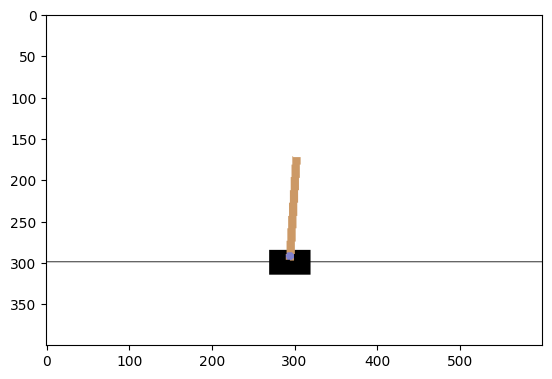

In [5]:
inverted_pendulum.test_render()